In [1]:
# Import needed packages

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from PIL import Image
import cv2
import os
import random
from tqdm import tqdm
import pickle
import pandas as pd

In [2]:
# The base directory to images
# DATA_DIR = '../../../In-situ Meas Data/In-situ Meas Data/Melt Pool Camera Preprocessed PNG/'
DATA_DIR = '../../../RTC_Images/'

# The size to transform the images to
IMG_SIZE = 50

# The range of clusters to test
MIN_K = 2
MAX_K = 140

### Load the data 

In [8]:
# Count the total number of images and create an empty array to hold the data
total_images = 0
for dir in os.listdir(DATA_DIR):
    image_list = os.listdir(DATA_DIR + dir)
    total_images += len(image_list)
print('Total Number of Images: ' + str(total_images))

# Empty array to hold the data
meltpools = np.zeros((total_images, IMG_SIZE*IMG_SIZE), dtype=np.uint8)
meltpools_name = list() # to hold the name of each meltpool for later use

Total Number of Images: 41806


In [9]:
# Now load data into meltpool array
counts = 0
for dir in tqdm(os.listdir(DATA_DIR)):
    for meltpool_image in os.listdir(DATA_DIR + dir):
        im = cv2.imread(DATA_DIR + dir + '/' + meltpool_image, cv2.IMREAD_GRAYSCALE)
        im = cv2.resize(im, (IMG_SIZE, IMG_SIZE))
        imArray = np.array(im)

        meltpools[counts,:] = imArray.flatten()
        meltpools_name.append(DATA_DIR + dir + '/' + meltpool_image)
        counts += 1

# Save the melt pools so don't need to load every time
np.save("K_Means_Meltpools_RTC", meltpools)
np.save("K_Means_Meltpools_Name_RTC", meltpools_name)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:27<00:00, 13.94s/it]


In [3]:
# Load the preprocessed data
meltpools = np.load("K_Means_Meltpools_RTC.npy")
meltpools_name = np.load("K_Means_Meltpools_Name_RTC.npy")

### Perform K-Means Once as a Demonstration

In [10]:
mini_batch_kmeans_model = MiniBatchKMeans(n_clusters=2, n_init='auto', batch_size=2048) # do K-Means with mini batch for improved speed

In [11]:
mini_batch_kmeans_model.fit(meltpools)

MiniBatchKMeans(batch_size=2048, n_clusters=2, n_init='auto')

In [12]:
clusters = mini_batch_kmeans_model.predict(meltpools)

In [13]:
centroids = mini_batch_kmeans_model.cluster_centers_

In [88]:
# Just saving for testing
np.save("clusters", clusters[2])
np.save("centroids", centroids[2])

In [4]:
clusters = np.load("clusters.npy")
centroids = np.load("centroids.npy")

### Run K-Means on range of Cluster Numbers 

In [14]:
centroids = dict()
clusters = dict()
for k in tqdm(range(MIN_K,MAX_K+1,1)):
    mini_batch_kmeans_model = MiniBatchKMeans(n_clusters=k, n_init='auto', batch_size=2048) # do K-Means with mini batch for improved speed
    mini_batch_kmeans_model.fit(meltpools)
    clusters[k] = mini_batch_kmeans_model.predict(meltpools)
    centroids[k] = mini_batch_kmeans_model.cluster_centers_

100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [09:10<00:00,  3.96s/it]


In [66]:
print(clusters)
print(centroids)

{2: array([0, 1, 1, ..., 1, 1, 1], dtype=int32), 3: array([2, 1, 1, ..., 0, 1, 1], dtype=int32), 4: array([1, 2, 0, ..., 0, 2, 2], dtype=int32), 5: array([1, 2, 0, ..., 0, 3, 3], dtype=int32), 6: array([1, 4, 0, ..., 2, 5, 5], dtype=int32), 7: array([2, 3, 1, ..., 6, 5, 5], dtype=int32), 8: array([1, 4, 5, ..., 2, 3, 3], dtype=int32), 9: array([2, 8, 4, ..., 0, 1, 1], dtype=int32), 10: array([1, 5, 7, ..., 8, 7, 7], dtype=int32), 11: array([2, 0, 8, ..., 3, 8, 8], dtype=int32), 12: array([ 1, 10,  5, ...,  2,  0,  7], dtype=int32), 13: array([0, 6, 1, ..., 2, 4, 4], dtype=int32), 14: array([ 1,  5,  8, ...,  7, 13,  0], dtype=int32), 15: array([ 2,  9,  7, ..., 10,  8,  8], dtype=int32), 16: array([ 2,  8,  6, ...,  3, 12, 12], dtype=int32), 17: array([ 1,  3, 16, ..., 13, 14,  7], dtype=int32), 18: array([ 2, 10, 12, ..., 15,  4,  4], dtype=int32), 19: array([0, 6, 3, ..., 5, 9, 1], dtype=int32), 20: array([ 1,  9,  0, ...,  8, 12, 12], dtype=int32), 21: array([ 1,  5,  6, ..., 15,  3

In [15]:
# Save the data
with open('centroids_RTC.pkl', 'wb') as fp:
    pickle.dump(centroids, fp)
    
with open('clusters_RTC.pkl', 'wb') as fp:
    pickle.dump(clusters, fp)

In [4]:
# Load the data
with open('centroids_RTC.pkl', 'rb') as fp:
    centroids = pickle.load(fp)
    
with open('clusters_RTC.pkl', 'rb') as fp:
    clusters = pickle.load(fp)

### Silhouette Analysis 

In [5]:
def Silhouette(data, labels, centers):
    num_data = data.shape[0]
    k = centers.shape[0]

    a = np.zeros((num_data, 1))
    b = np.zeros((num_data, 1))
    s = np.zeros((num_data, 1))
    for i in tqdm(range(num_data)):  # Iterate through each image
        cluster = labels[i]
        d = list()

        distance = np.zeros((num_data, 1))

        # Perform the calculation in batches for improved speed
        indx = 0
        for j in range(0, num_data, num_data):
            dist = np.square(data[indx:j,:] - data[i,:].astype('int32'))
            distance[indx:j] = np.sum(dist, axis=1, keepdims=True)
            indx = j
        dist = np.square(data[indx:, :] - data[i,:].astype('int32'))
        distance[indx:] = np.sum(dist, axis=1, keepdims=True)

        distance = np.sqrt(distance)
        for j in range(k):  # Iterate through each cluster
            cluster_j_indx = (labels == j)
            cluster_j_indx[i] = False
            # num_cluster_j_data = np.sum(cluster_j_indx)
            # cluster_j_data = data[cluster_j_indx, :]

            distances = distance[cluster_j_indx]
            if (j == cluster):  # Same cluster as image
                a[i] = np.mean(distances)
            else:  # a different cluster
                d.append(np.mean(distances))

        b[i] = np.min(np.array(d))

    denom = np.maximum(a, b)
    s = (b - a) / denom
    return np.mean(s)

In [6]:
sil = Silhouette(meltpools, clusters[2], centroids[2])
# Todo: Run on GPU to see how long will take

  0%|                                                                         | 29/1033611 [01:58<1171:07:30,  4.08s/it]


KeyboardInterrupt: 

In [18]:
silhouettes = list()
for k in tqdm(range(MIN_K,MAX_K+1,1)):
    sil = silhouette_score(meltpools, clusters[k], metric='euclidean', sample_size=10000, random_state=25)
    silhouettes.append(sil)
np.save("silhouettes_RTC", np.array(silhouettes))

100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [10:37<00:00,  4.59s/it]


In [5]:
silhouettes = np.load("silhouettes_RTC.npy")

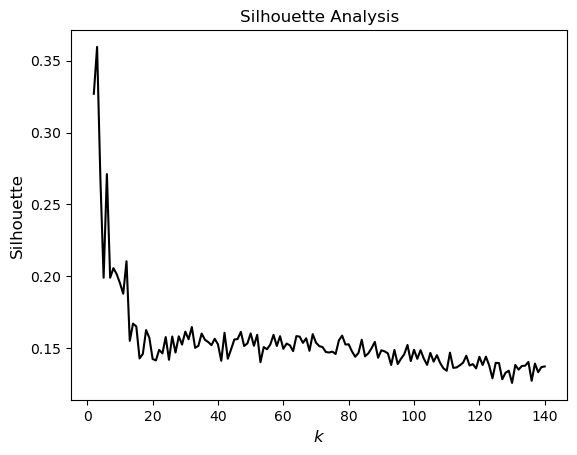

In [6]:
plt.plot(range(2,MAX_K+1,1), silhouettes[:], c='k')
plt.title('Silhouette Analysis')
plt.xlabel(r'$k$', fontsize=12)
plt.ylabel('Silhouette', fontsize=12)

# plt.savefig('Plots/silhouette_images', dpi=600)
# plt.savefig('Plots/silhouette_images_LowRes', dpi=150)

plt.show()

### T-SNE on the clusters

In [6]:
SAMPLE_K = 60

centroids_embedded = TSNE(n_components=2, perplexity=5.0).fit_transform(centroids[SAMPLE_K])

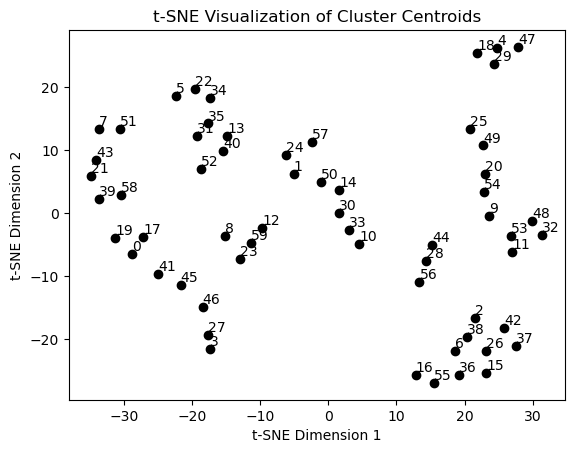

In [7]:
fig, ax = plt.subplots()
ax.scatter(centroids_embedded[:,0], centroids_embedded[:,1], c='k')
for i in range(SAMPLE_K):
    ax.annotate(str(i), (centroids_embedded[i,0], centroids_embedded[i,1]+0.5))

plt.title('t-SNE Visualization of Cluster Centroids')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
# plt.savefig('Plots/t-sne_centroids', dpi=600)
# plt.savefig('Plots/t-sne_centroids_LowRes', dpi=150)
plt.show()

### Analysis of Clusters

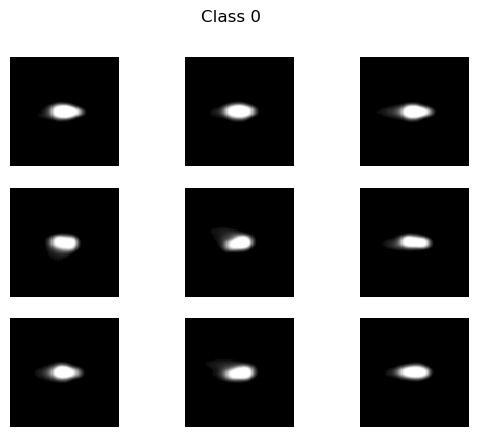

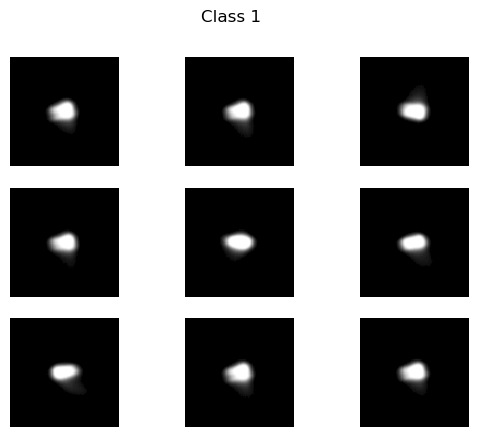

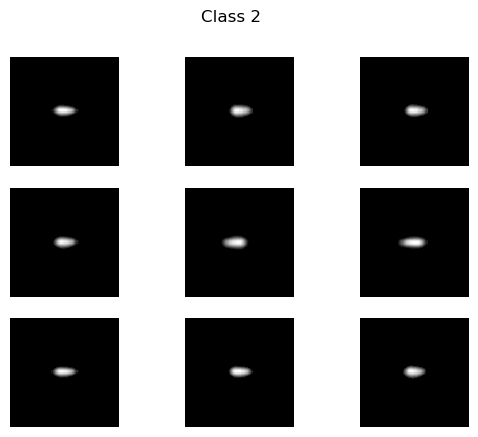

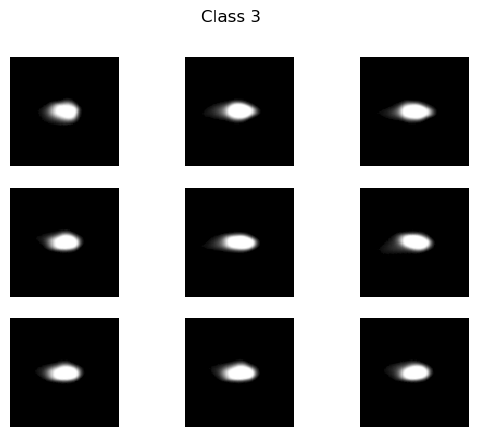

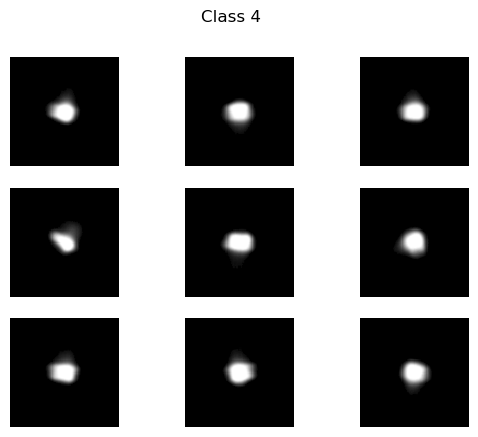

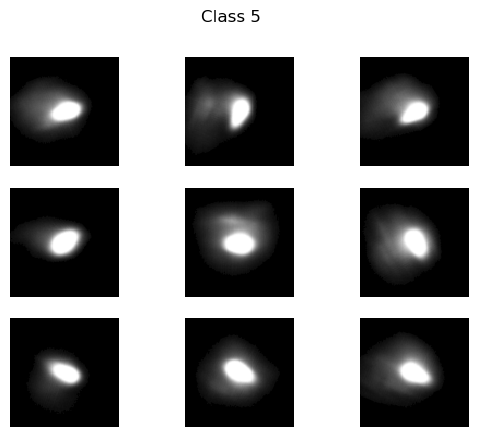

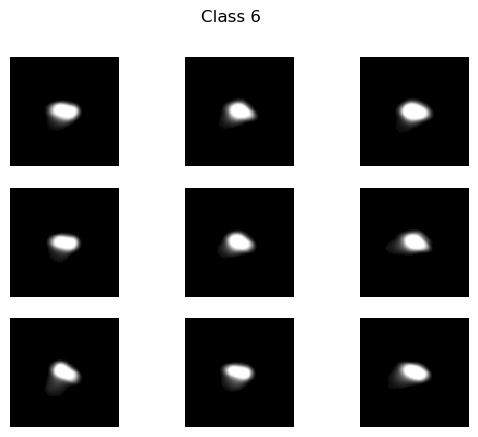

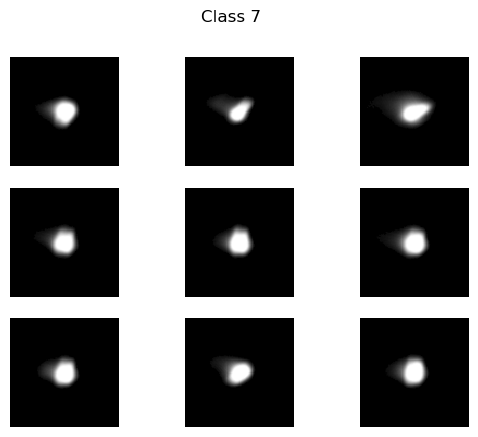

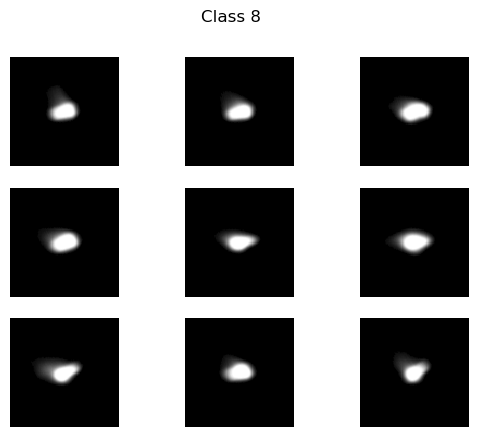

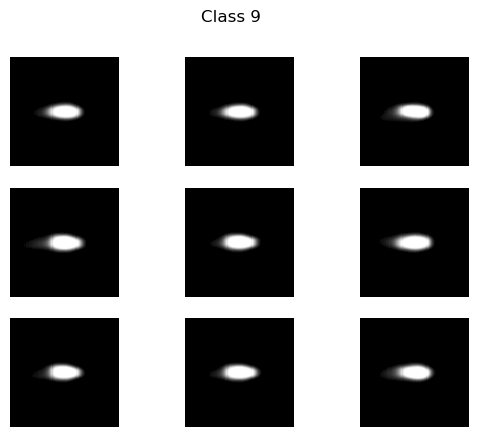

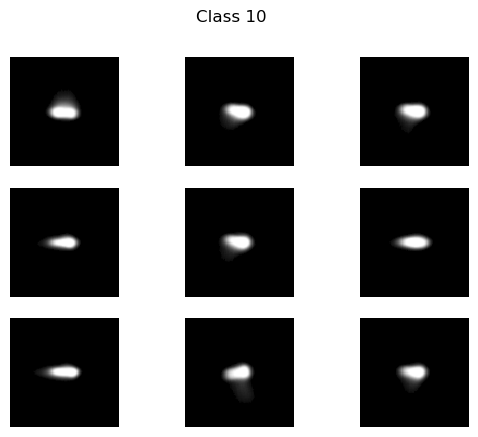

In [8]:
# Select Number of clusters to analyze:
k = 11
grid_size = 3

###############################
for ii in range(k):
    num = 0
    
    loc = (clusters[k] == ii).nonzero()
    
    fig, axs = plt.subplots(grid_size,grid_size)
    fig.suptitle('Class ' + str(ii))
    for jj in range(grid_size):
        for kk in range(grid_size):
            meltpool_class_ii = meltpools_name[loc[0][random.randint(0, len(loc[0])-1)]]
            im = cv2.imread(meltpool_class_ii, cv2.IMREAD_GRAYSCALE)
            imArray = np.array(im)
            axs[jj,kk].imshow(imArray, cmap='gray', interpolation='nearest')
            # axs[jj,kk].imshow(doughnutImages[:,:, loc[0][num]], cmap='gray', interpolation='nearest')
            # axs[jj,kk].imshow(doughnutImages[:,:, loc[0][random.randint(0, len(loc[0])-1)]], cmap='gray', interpolation='nearest')
            axs[jj,kk].axis('off')
            num += 1

### Now sort data to prepare for neural network training (If not doing cluster of clusters)

In [25]:
labels = pd.DataFrame({'image_name': meltpools_name, 'label': clusters[12]})

In [27]:
labels.to_excel('K_means_labels_RTC.xlsx',header=False, index=False)

In [28]:
all_data = pd.read_excel('K_means_labels_RTC.xlsx', header=None)
cluster_assignment = np.array(all_data[1])
image_name = np.array(all_data[0])

In [29]:
train_percent = 0.8
dev_percent = 0.1
test_percent = 0.1

In [30]:
total_images = cluster_assignment.shape[0]
indices = np.random.permutation(cluster_assignment.shape[0])
train_indices = indices[0:int(train_percent*total_images)]
dev_indices = indices[int(train_percent*total_images):int((train_percent+dev_percent)*total_images)]
test_indices = indices[int((train_percent+dev_percent)*total_images):]

In [31]:
train_cluster_assignment = cluster_assignment[train_indices]
train_image_name = image_name[train_indices]

dev_cluster_assignment = cluster_assignment[dev_indices]
dev_image_name = image_name[dev_indices]

test_cluster_assignment = cluster_assignment[test_indices]
test_image_name = image_name[test_indices]

In [32]:
train_data = pd.DataFrame({'image_name': train_image_name, 'label': train_cluster_assignment})
dev_data = pd.DataFrame({'image_name': dev_image_name, 'label': dev_cluster_assignment})
test_data = pd.DataFrame({'image_name': test_image_name, 'label': test_cluster_assignment})

train_data.to_excel('neural_network_data/train_labels_RTC.xlsx',header=False, index=False)
dev_data.to_excel('neural_network_data/dev_labels_RTC.xlsx',header=False, index=False)
test_data.to_excel('neural_network_data/test_labels_RTC.xlsx',header=False, index=False)

### Do a cluster of clusters 

In [11]:
MIN_K2 = 2
MAX_K2 = 50
SAMPLE_K = 60

In [12]:
centroids2 = dict()
clusters2 = dict()
clusters2_meltpools = dict()
for k in tqdm(range(MIN_K2,MAX_K2+1,1)):
    kmeans_model_round2 = KMeans(n_clusters=k, n_init='auto') # the standard K-Means
    kmeans_model_round2.fit(centroids[SAMPLE_K])
    clusters2[k] = kmeans_model_round2.predict(centroids[SAMPLE_K])
    clusters2_meltpools[k] = kmeans_model_round2.predict(meltpools)
    centroids2[k] = kmeans_model_round2.cluster_centers_

# Save the data
with open('centroids2_RTC.pkl', 'wb') as fp:
    pickle.dump(centroids2, fp)
    
with open('clusters2_RTC.pkl', 'wb') as fp:
    pickle.dump(clusters2, fp)
    
with open('clusters2_meltpools_RTC.pkl', 'wb') as fp:
    pickle.dump(clusters2_meltpools, fp)

100%|███████████████████████████████████████████████████████████████████████████████████| 49/49 [00:31<00:00,  1.54it/s]


In [9]:
# Load the data
with open('centroids2_RTC.pkl', 'rb') as fp:
    centroids2 = pickle.load(fp)
    
with open('clusters2_RTC.pkl', 'rb') as fp:
    clusters2 = pickle.load(fp)
    
with open('clusters2_meltpools_RTC.pkl', 'rb') as fp:
    clusters2_meltpools = pickle.load(fp)

In [12]:
silhouettes2 = list()
silhouettes2_meltpool = list()
for k in tqdm(range(MIN_K2,MAX_K2,1)):
    sil = silhouette_score(centroids[SAMPLE_K], clusters2[k], metric='euclidean')
    sil2 = silhouette_score(meltpools, clusters2_meltpools[k], metric='euclidean', sample_size=10000, random_state=25)
    silhouettes2.append(sil)
    silhouettes2_meltpool.append(sil2)
silhouettes2 = np.array(silhouettes2)
silhouettes2_meltpool = np.array(silhouettes2_meltpool)

  8%|██████▉                                                                            | 4/48 [00:18<03:20,  4.56s/it]


KeyboardInterrupt: 

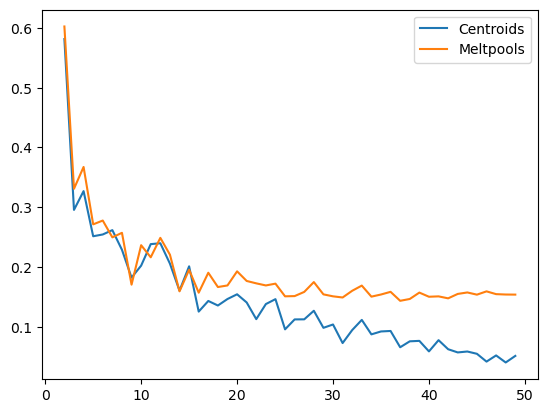

In [15]:
plt.plot(range(MIN_K2,MAX_K2,1), silhouettes2)
plt.plot(range(MIN_K2,MAX_K2,1), silhouettes2_meltpool)
plt.legend(['Centroids', 'Meltpools'])
plt.show()

[ WARN:0@238.301] global loadsave.cpp:244 findDecoder imread_('../../../RTC_Images/MPA/layer1_19791.png'): can't open/read file: check file path/integrity


TypeError: Image data of dtype object cannot be converted to float

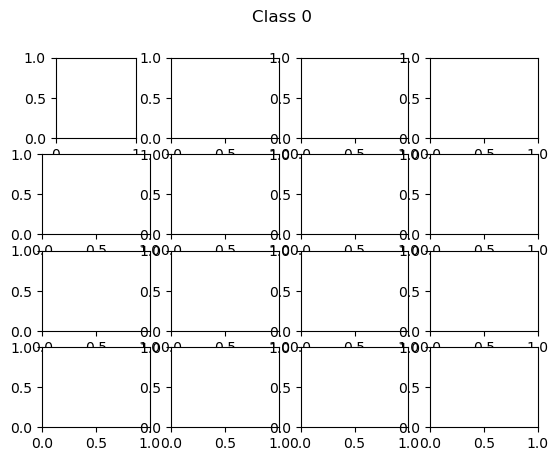

In [16]:
# Select Number of clusters to analyze:
k = 8
grid_size = 4

###############################
for ii in range(k):
    num = 0
    
    loc = (clusters2_meltpools[k] == ii).nonzero()
    
    fig, axs = plt.subplots(grid_size,grid_size)
    fig.suptitle('Class ' + str(ii))
    for jj in range(grid_size):
        for kk in range(grid_size):
            meltpool_class_ii = meltpools_name[loc[0][random.randint(0, len(loc[0])-1)]]
            im = cv2.imread(meltpool_class_ii, cv2.IMREAD_GRAYSCALE)
            imArray = np.array(im)
            axs[jj,kk].imshow(imArray, cmap='gray', interpolation='nearest')
            # axs[jj,kk].imshow(doughnutImages[:,:, loc[0][num]], cmap='gray', interpolation='nearest')
            # axs[jj,kk].imshow(doughnutImages[:,:, loc[0][random.randint(0, len(loc[0])-1)]], cmap='gray', interpolation='nearest')
            axs[jj,kk].axis('off')
            num += 1

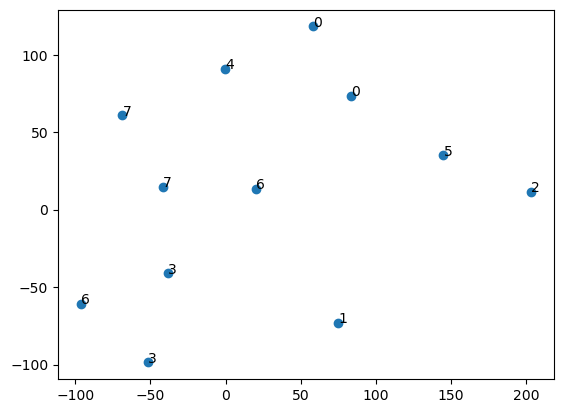

In [16]:
fig, ax = plt.subplots()
ax.scatter(centroids_embedded[:,0], centroids_embedded[:,1])
for i in range(SAMPLE_K):
    ax.annotate(str(clusters2[8][i]), (centroids_embedded[i,0], centroids_embedded[i,1]))

plt.show()

### Now try clustering the clusters based on T-SNE 

In [21]:
MIN_K3 = 2
MAX_K3 = 50

centroids3 = dict()
clusters3 = dict()
# clusters3_meltpools = dict()
for k in tqdm(range(MIN_K3,MAX_K3+1,1)):
    kmeans_model_round3 = KMeans(n_clusters=k, n_init='auto') # the standard K-Means
    kmeans_model_round3.fit(centroids_embedded)
    clusters3[k] = kmeans_model_round3.predict(centroids_embedded)
#     clusters3_meltpools[k] = kmeans_model_round3.predict(meltpools)
    centroids3[k] = kmeans_model_round3.cluster_centers_


  0%|                                                                                           | 0/49 [00:00<?, ?it/s]C:\Users\satom\anaconda3\envs\meltpool_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\satom\anaconda3\envs\meltpool_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\satom\anaconda3\envs\meltpool_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable

C:\Users\satom\anaconda3\envs\meltpool_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\satom\anaconda3\envs\meltpool_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\satom\anaconda3\envs\meltpool_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\satom\anaconda3\envs\meltpool_env\Lib\site-packages\sklearn\cluster\_kmea

In [22]:
silhouettes3 = list()
for k in tqdm(range(MIN_K3,MAX_K3,1)):
    sil = silhouette_score(centroids_embedded, clusters3[k], metric='euclidean')
    silhouettes3.append(sil)
silhouettes3 = np.array(silhouettes3)

print('Best Silhouette value is ' + str(np.max(silhouettes3[5:])) +  ' at k=' + str(np.argmax(silhouettes3[5:])+7))
best_k = np.argmax(silhouettes3[5:])+7



100%|████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 1115.59it/s]

Best Silhouette value is 0.5483949 at k=11


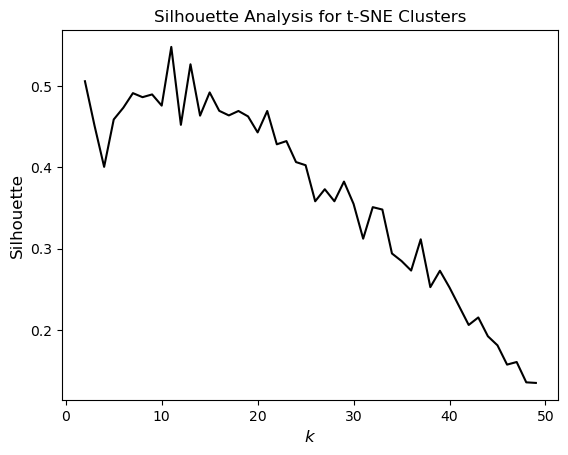

In [23]:
plt.plot(range(MIN_K3,MAX_K3,1), silhouettes3, c='k')
plt.title('Silhouette Analysis for t-SNE Clusters')
plt.xlabel(r'$k$', fontsize=12)
plt.ylabel('Silhouette', fontsize=12)
# plt.savefig('Plots/silhouette_tSNE', dpi=600)
# plt.savefig('Plots/silhouette_tSNE_LowRes', dpi=150)
plt.show()

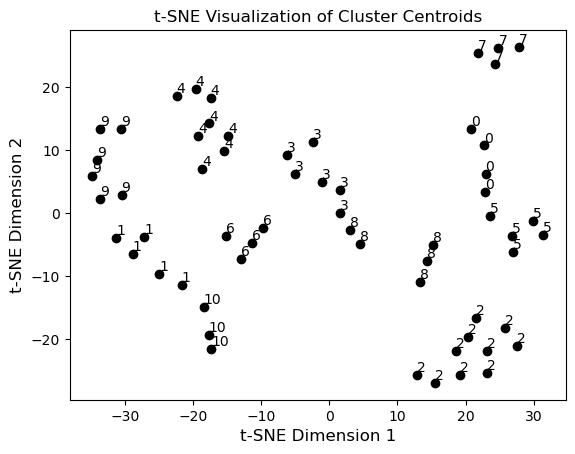

In [24]:
fig, ax = plt.subplots()
ax.scatter(centroids_embedded[:,0], centroids_embedded[:,1], c='k')
plt.title('t-SNE Visualization of Cluster Centroids')
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)

# plt.savefig('Plots/t-sne_centroids_unlabeled', dpi=600)
# plt.savefig('Plots/t-sne_centroids_unlabeled_LowRes', dpi=150)

for i in range(SAMPLE_K):
    ax.annotate(str(clusters3[best_k][i]), (centroids_embedded[i,0], centroids_embedded[i,1]+0.5))
    
# plt.savefig('Plots/t-sne_centroids', dpi=600)
# plt.savefig('Plots/t-sne_centroids_LowRes', dpi=150)

plt.show()

In [25]:
updated_clusters = np.zeros(clusters[SAMPLE_K].shape)
old_clusters = clusters[SAMPLE_K]
for ii in range(SAMPLE_K):
    indx = np.argwhere(old_clusters == ii)
    updated_clusters[indx] = clusters3[best_k][ii]

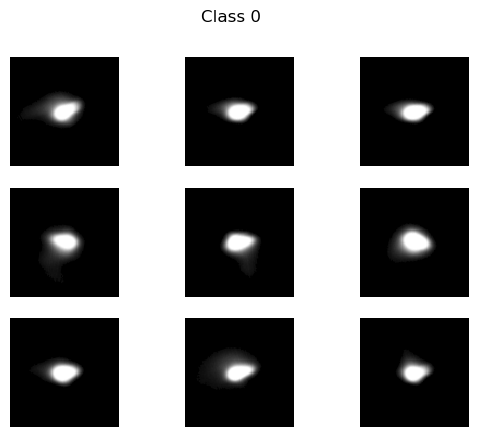

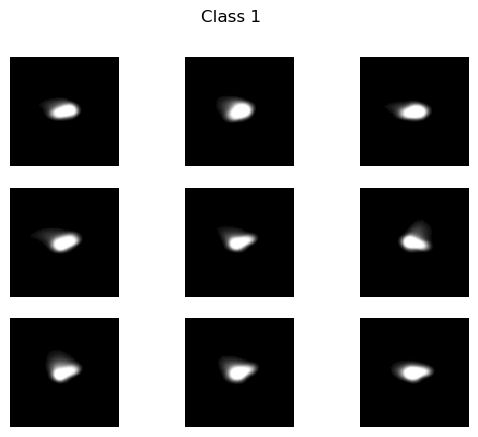

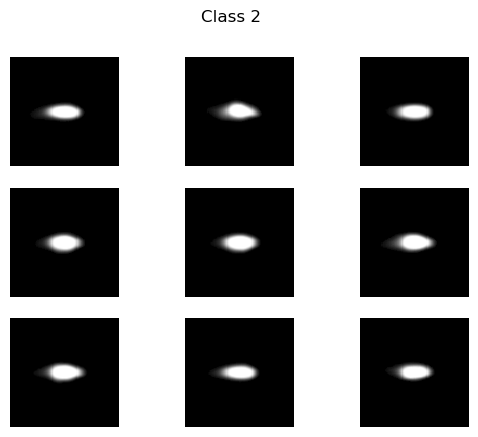

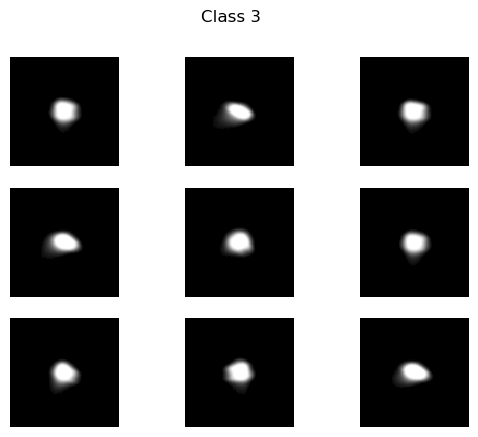

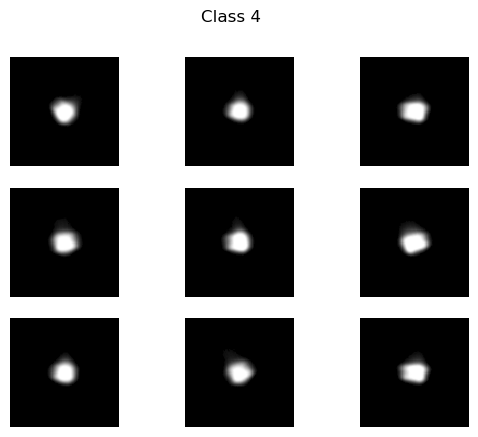

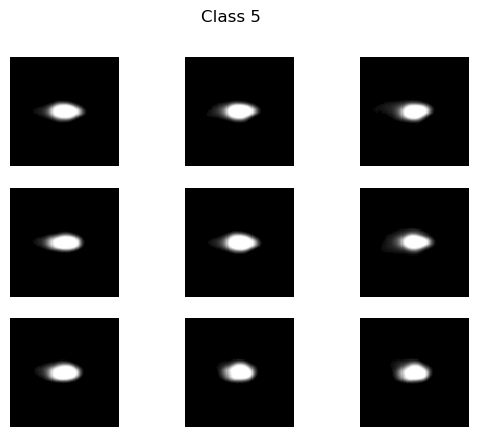

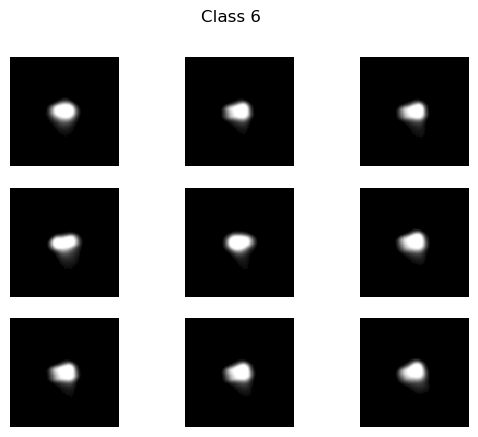

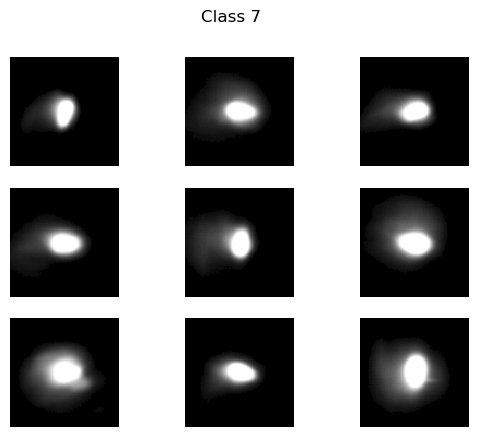

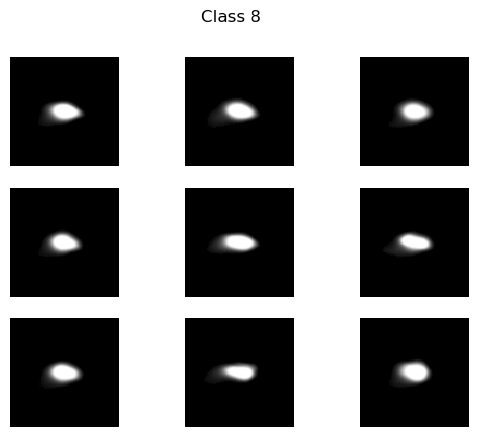

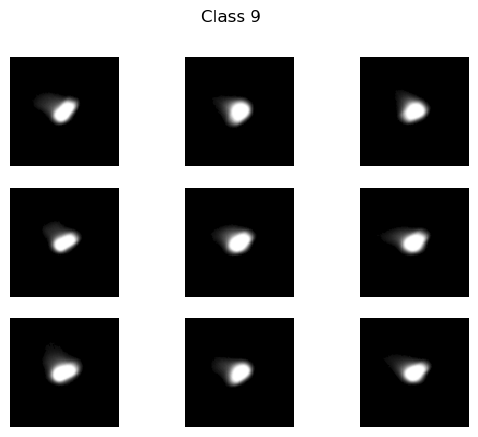

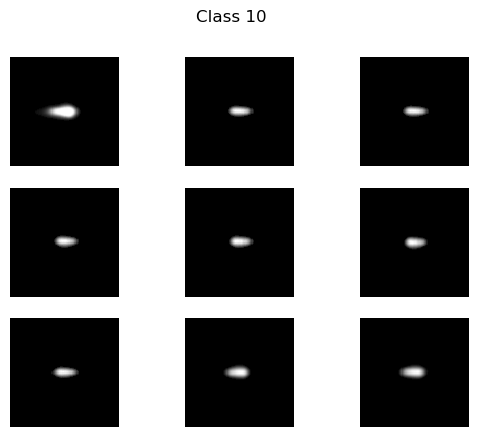

In [26]:
# Select Number of clusters to analyze:
k = best_k
grid_size = 3

###############################
for ii in range(k):
    num = 0
    
    loc = (updated_clusters == ii).nonzero()
    
    fig, axs = plt.subplots(grid_size,grid_size)
    fig.suptitle('Class ' + str(ii))
    for jj in range(grid_size):
        for kk in range(grid_size):
            meltpool_class_ii = meltpools_name[loc[0][random.randint(0, len(loc[0])-1)]]
            im = cv2.imread(meltpool_class_ii, cv2.IMREAD_GRAYSCALE)
            imArray = np.array(im)
            axs[jj,kk].imshow(imArray, cmap='gray', interpolation='nearest')
            # axs[jj,kk].imshow(doughnutImages[:,:, loc[0][num]], cmap='gray', interpolation='nearest')
            # axs[jj,kk].imshow(doughnutImages[:,:, loc[0][random.randint(0, len(loc[0])-1)]], cmap='gray', interpolation='nearest')
            axs[jj,kk].axis('off')
            num += 1

### Now sort data to prepare for neural network training 

In [27]:
labels = pd.DataFrame({'image_name': meltpools_name, 'label': updated_clusters})

In [28]:
labels.to_excel('K_means_labels_RTC11.xlsx',header=False, index=False)

In [29]:
all_data = pd.read_excel('K_means_labels_RTC11.xlsx', header=None)
cluster_assignment = np.array(all_data[1])
image_name = np.array(all_data[0])

In [30]:
train_percent = 0.8
dev_percent = 0.1
test_percent = 0.1

In [31]:
total_images = cluster_assignment.shape[0]
indices = np.random.permutation(cluster_assignment.shape[0])
train_indices = indices[0:int(train_percent*total_images)]
dev_indices = indices[int(train_percent*total_images):int((train_percent+dev_percent)*total_images)]
test_indices = indices[int((train_percent+dev_percent)*total_images):]

In [32]:
train_cluster_assignment = cluster_assignment[train_indices]
train_image_name = image_name[train_indices]

dev_cluster_assignment = cluster_assignment[dev_indices]
dev_image_name = image_name[dev_indices]

test_cluster_assignment = cluster_assignment[test_indices]
test_image_name = image_name[test_indices]

In [33]:
train_data = pd.DataFrame({'image_name': train_image_name, 'label': train_cluster_assignment})
dev_data = pd.DataFrame({'image_name': dev_image_name, 'label': dev_cluster_assignment})
test_data = pd.DataFrame({'image_name': test_image_name, 'label': test_cluster_assignment})

train_data.to_excel('neural_network_data/train_labels_RTC11.xlsx',header=False, index=False)
dev_data.to_excel('neural_network_data/dev_labels_RTC11.xlsx',header=False, index=False)
test_data.to_excel('neural_network_data/test_labels_RTC11.xlsx',header=False, index=False)